# Variational Autoencoder for the MNIST-Data-Set

Tobias Haase

In the following I adapted [a blog on VAEs in particular for this data-set](https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/). From this blog I took the basic code and then tried to understand whats going on from there. 

## Set Up
Firstly I am loading the required modules.

In [4]:

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio 

Then I will define the functions I will use to train and validate the network. 

Firstly, the loss function is defined. The KL divergence is computed manually. There are three inputs: Firstly the reconstruction loss. 
Then there are the mean and the variance, which are related to the VAE's latent space.
The loss is defined as the sum of the KL divergence and the reconstruction loss here, thus the sum is returned as the final loss.  


In [5]:

def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


Next, the training function is defined. This takes the criterion refers to the loss function, which is the criterion that needs to be minimized. 

In [6]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1  #There is a counter that is initialized at 0, which goes up for every batch?
        data = data[0]
        data = data.to(device) # All computations are supposed to be computed on my GPU. 
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()  # Using the loss, backpropagation occurs. Thus, all the tensors that will be connected to this, will be involved in this computation. 
        running_loss += loss.item() #This here defined for every step along the way, how high is the loss. 
        optimizer.step()  #That with a gradient will be updated in one step according to the documentation. 
    train_loss = running_loss / counter 
    return train_loss #The function returns only the training loss. 

Lastly, we need to validate that the training worked. Two things differentiate this from the training: Firstly, there is no backpropagation step here! The evaluation  does not impact the training. Then, images are saved. This is saved then according to the functions outlined in the utilis section. 


In [7]:

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

### Utility functions
 This section contains utility functions related to saving plots and images. They should not clutter up the training part as they are not relevant to training. 

In [8]:
to_pil_image = transforms.ToPILImage() #conversion of a tensor to an image, this will later be used to generate .gif images!

#The following function converts the PILutilityges to .gif files. The accepted data are numpy arrays!
def image_to_vid(images):     
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('../outputs/generated_images.gif', imgs)

#This function is equal to the function above, but for outputs of the VAE
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"../outputs/output{epoch}.jpg")  #The save image function comes from torchvision.utilis!

#Finally, here the training and validation losses are saved into a plot! This is done via matplotlib. 
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../outputs/loss.jpg')
    plt.show()

## Model

Next I will define the parameters for the model. 
The kernel size is 4x4. This means that there is a 4 pixel wide and high kernel that is used for the convolutioin. 

In [9]:
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters, first layers output. 
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

In the next step the full model is formulated.

In [10]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder - Initially the VAE has a few convolutional layers that increase in the amount of channels. This is common practice, later fully connected layers reduce the amount of channels to the desired amount. 
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations <-- here there is the bottleneck
        self.fc1 = nn.Linear(64, 128)
            # Using the 128 nodes as input for the bottleneck, the mean and variance of the latent channels are computed. 
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        self.latent_dim = latent_dim

        # decoder 
        # Here there is the reverse ordere of the encoder, starting with 0 padding and moving on to a kernel with padding. 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
       
    #The following is what allows us to backpropagate throught the model. One cannot do so through a random node, but we can sample from a random node and with the reparametrization trick 
    # still backpropagate through not random / deterministic nodes!
    def reparameterize(self, mu, log_var):
        """s
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size - this returns a vector filled with random entries. 
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding: Passing the input through the convolution layers. We have Relu functions here (dimensionality reduction?)
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)  # This is an adaptive pooling layer. The last part is a common reshaping step. 
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z) # in this layer the reparametrization trick is applied. 
        z = z.view(-1, 64, 1, 1) # This is a reshaping step.
 
        # decoding; 
        torch.manual_seed(0)
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x)) #Sigmoid for the final layer, this is fitting as we use cross entropy as to compute the loss? Linear functions would be associated with mean squared errors etc. 
        return reconstruction, mu, log_var

In [5]:
import torch

tensor = torch.randn(16, 8, 8)
reshaped_tensor = tensor.view(tensor.size(1), -1)
print(reshaped_tensor.shape)

torch.Size([8, 128])


## Training

Firstly a few preparations are done. 

In [11]:
matplotlib.style.use('ggplot')
# Firstly, the device is set to the GPU instead of the CPU for me, as I have cuda available. 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model - here a convolutional VAE is used which will be computed on my GPU. What does this mean? It uses a convolution to analyze the images. 
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001  # I have no idea if this is large. 
epochs = 100
batch_size = 64
# Trained 100 rounds, 64 samples each episode.  
optimizer = optim.Adam(model.parameters(), lr=lr)  # An ADAM optimizer is used. This means that the optimization occurs in one step, although I still need to read more on what this does exactly. 
criterion = nn.BCELoss(reduction='sum')  #BCE stands for Binary Cross Entropy, thus cross entropy is used as the criterion. 
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []  #An empty list is created. 




Now lets check if cuda is actually used:

In [12]:
device

device(type='cuda')

The data is transformed and loaded in the following. 

In [13]:
# --- Data Transformation: 
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# The original data-set available from MNIST have a size of 28x28 pixels. Above they are transformed. 

# --- training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
# The data-set is loaded. It comes from the source of torchvision.data.set and is downloaded. 
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# Here is the important set of actually loading the data. The batch sizes are also defined, thus it is defined how data will be sampled for later training?

# --- validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

Let's check the type of objects loaded via the data-loader. 

In [22]:
images, _ = next(iter(trainloader))
type(images[23])


for idx, x in enumerate(images):
    if not torch.is_tensor(x):
        print("Non-tensor image found! This is of the type:", type(x))
        # Handle the case when a non-tensor background is encountered
    else:
        # Process the background tensor
        # ...
        pass

Thus, every epoch 64 samples are run through the model. 

In [14]:
print("Overall the train portion of the data-set has a length of %f", len(trainset))
print("Overall the test portion of the data-set has a length of %f", len(testset))

trainloader
trainset

Overall the train portion of the data-set has a length of %f 60000
Overall the test portion of the data-set has a length of %f 10000


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../input
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

Again empty lists are initialized for the training loss and the validation loss to allow for later plotting. 

In [1]:
train_loss = []
valid_loss = []

Here the training function is defined. For every epoch in the range of epochs the following function will be computed. This means that for the first episode
I will draw from the training set, compute the loss, backpropagate and rinse and repeat. 
The bread and butter of this are the train and validate functions. they require the input of the model, what data will be used to train, what data will be used to test. 
What is the device (for me GPU), then how will it be optimized (ADAM), in regards to the previously defined criterion of binary cross entropy. 


In [15]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    # Next the values that result from this will be stored. 
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format, which can then be saved!
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}") #Up to 4 decimals will be printed, float format. 

# save the reconstructions as a .gif file
image_to_vid(grid_images)
# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

Epoch 1 of 100


 18%|█▊        | 172/937 [00:02<00:09, 79.66it/s] 


KeyboardInterrupt: 

Now that the training is complete, lets save the weights so I can later use them to analyze the latent space. 

In [ ]:
torch.save(model.state_dict(), 'vae_weights.pth')

In [ ]:
model = ConvVAE()
model.load_state_dict(torch.load('vae_weights.pth'))

Now lets try to generate the latent dimension with some of the images from the MNIST data-set. 

What am I trying to do here - still does not work:

Define a function that takes the batch from the batch loader as an input. It uses the previously trained images. 
* the model is set to evaluation mode so nothing is changed. 
* I initialized an empty list so the encoded representations can be stored. 
* Gradient calculations are disabled, this is not meant for learning. 
* The for loop here is supposed to do the following: Iterate throught the batchloader, but ignore the output. Thus, it only loops throught he input. Don't know if this makes sense, this was recommended by ChatGPT. Need to play around with it to see the consequences. 
* Appends the encoded batch to the list, concatenates it, results in tensor - shape of the batch size x the latent dimension. So a value for each piece object in the batch for each latent dimension. Returns the encoded images, this should be a tensor. 

In [ ]:
batch = torchvision.datasets.MNIST(root='../input', train=False, download=True, transform=transform)

batchloader = DataLoader(batch, batch_size= 8, shuffle=False)


def encode_images(images):
    model.eval()  # Set the model to evaluation mode
    encoded_images = []
    with torch.no_grad():
       for batch_images, _ in batchloader:
            batch_images = batch_images.to(device)
            encoded_batch, _, _ = model(batch_images)
            encoded_images.append(encoded_batch)
    encoded_images = torch.cat(encoded_images, dim=0)
    return encoded_images

First let's quickly check if I am still using cuda.

In [ ]:
print("Device:", device)

Device: cuda


In [ ]:
# Encode a batch of MNIST images
encoded_batch = encode_images(batchloader)

### Visualization

Here I try to visualize the latent diimensions. The latent dimensions are reduced for this visualization. The process used here is t-SNE. This stands for t-Distributed Stochastic Neighbor Embedding. Its a dimensionality rss can indicate different classes or categories present in the data.

    Interpreting the t-SNE visualization involves analyzing the spatial arrangement of the points. Points that are close together on the scatter plot are likely to be similar in the high-dimensional space, indicating that they share certain characteristics or belong to the same cluster. Conversely, points that are far apart on the scatter plot are dissimilar in the high-dimensional space. Patterns, clusters, or groupings in the scatter plot can provide insights into the structure and relationships within the data.

    It's important to note that t-SNE is a stochastic algorithm, meaning that each run can produce slightly different results. Additionally, the distances between points on the scatter plot are not directly interpretable in terms of their exact similarity or dissimilarity. Instead, the relative positions and groupings of the points are more informative."


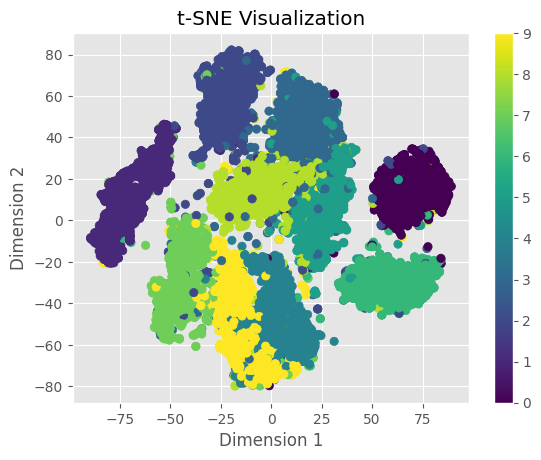

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

def visualize_tsne(encoded_batch, labels):
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
    encoded_batch_cpu = encoded_batch.cpu()
    encoded_batch_2d = np.reshape(encoded_batch_cpu, (encoded_batch_cpu.shape[0], -1))
    encoded_tsne = tsne.fit_transform(encoded_batch_2d)

    # Scatter plot
    plt.scatter(encoded_tsne[:, 0], encoded_tsne[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE Visualization')
    plt.show()

# Load MNIST dataset
mnist_dataset = datasets.MNIST(root='path/to/dataset', train=False, download=True)
labels = mnist_dataset.targets.numpy()

# Visualizing
visualize_tsne(encoded_batch, labels)


### Generation

The function below is called "generate_samples_from_latent_space". As the name suggests it **generates** synthetic **samples** from a Variational Autoencoder (VAE) model **given a specified latent dimension**. It sets the model to evaluation mode and generates random latent vectors of the specified dimension. The latent vectors are passed through the model's layers, including the fully connected layer (fc2) and the decoder layers (dec1, dec2, dec3, dec4). Here I didn't actually define a decoder within the VAE. I also had to go through the fully connected layers first, else the dimensions didn't match. The generated images are saved as an image files and displayed as a grid using matplotlib. The function allows users to specify the number of samples to generate and the desired latent dimension.

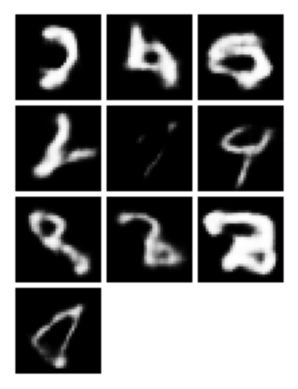

In [ ]:
import torchvision.utils as vutils

def generate_samples_from_latent_space(model, latent_dim, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, latent_dim).to(model.dec1.weight.device)  # Generate random latent vectors
        latent_samples = latent_samples.view(-1, latent_dim, 1, 1)  # Reshape the latent samples

        hidden = model.fc2(latent_samples.view(-1, latent_dim))  # Pass latent vectors through fc2 layer
        hidden = hidden.view(-1, 64, 1, 1)  # Reshape the hidden layer output

        # Pass through decoder layers
        x = F.relu(model.dec1(hidden))
        x = F.relu(model.dec2(x))
        x = F.relu(model.dec3(x))
        generated_images = torch.sigmoid(model.dec4(x))  # Apply sigmoid to the final layer output

    vutils.save_image(generated_images, 'generated_samples.png', normalize=True)
    grid = vutils.make_grid(generated_images, nrow=int(num_samples**0.5), normalize=True, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


# Usage
latent_dim = 16  # Set the desired number of latent dimensions
generate_samples_from_latent_space(model, latent_dim, num_samples=10)  # Generate 10 samples and save them as an image

But this really isnt too helpful if I dont know from where in the latent space the generated figures are drawn. 

Hint: Obviously I didn't do this on my own, I just wanted to see what ChatGPT can come up with. 

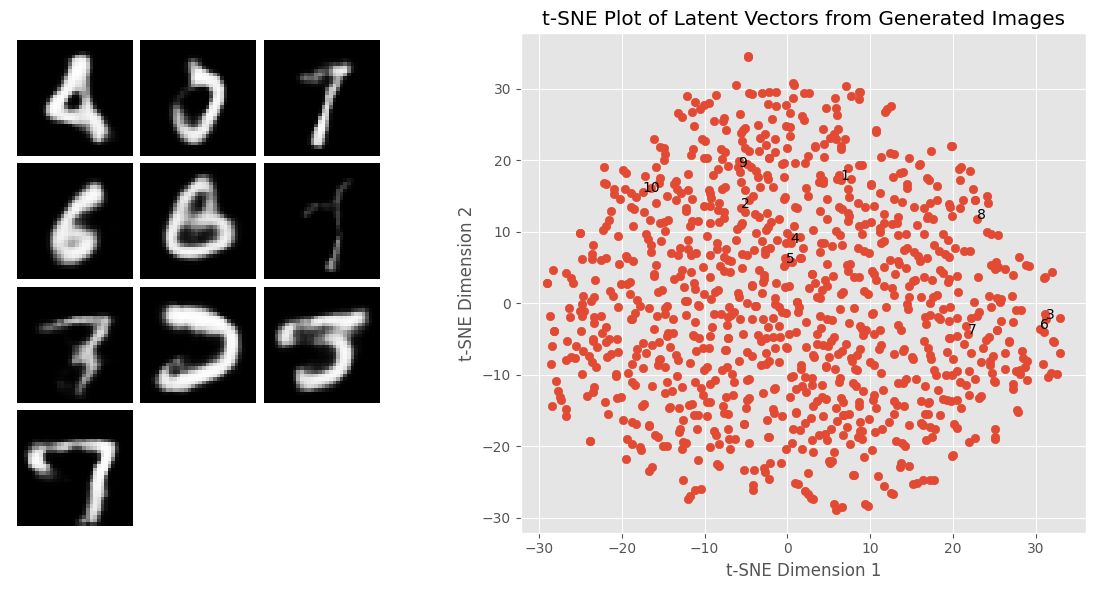

In [ ]:
import torchvision.utils as vutils
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def generate_samples_from_latent_space(model, latent_dim, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        latent_samples = torch.randn(1000, latent_dim).to(model.dec1.weight.device)  # Generate random latent vectors
        latent_samples = latent_samples.view(-1, latent_dim, 1, 1)  # Reshape the latent samples

        hidden = model.fc2(latent_samples.view(-1, latent_dim))  # Pass latent vectors through fc2 layer
        hidden = hidden.view(-1, 64, 1, 1)  # Reshape the hidden layer output

        # Pass through decoder layers
        x = F.relu(model.dec1(hidden))
        x = F.relu(model.dec2(x))
        x = F.relu(model.dec3(x))
        generated_images = torch.sigmoid(model.dec4(x))  # Apply sigmoid to the final layer output

        # Generate t-SNE plot for latent vectors of generated images
        generated_latent_vectors = hidden.view(-1, 64).cpu().numpy()
        tsne = TSNE(n_components=2, random_state=0, perplexity=30)
        generated_latent_vectors_tsne = tsne.fit_transform(generated_latent_vectors)

    vutils.save_image(generated_images[:num_samples], 'generated_samples.png', normalize=True)
    grid = vutils.make_grid(generated_images[:num_samples], nrow=int(num_samples**0.5), normalize=True, pad_value=1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
latent_dim = 16  # Set the desired number of latent dimensions
generate_samples_from_latent_space(model, latent_dim, num_samples=10)  # Generate 10 samples and display them along with the t-SNE plot


### Interpolation

Okay, now onto interpolation. One may ask oneself: What is the purpose of interpolation with handwritten digits? 

Well, this is mostly used for fun here. What would a number look like thats between the existing samples. When interpolating between existing latent vectors we can look at the space in between. This makes most sense when the latent variables are continous and the latent space is structured! 

In [ ]:
import torch
import torchvision.utils as vutils

def interpolate_samples(model, latent_dim, num_steps=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Select two random latent vectors for interpolation
        latent_start = torch.randn(latent_dim).to(model.dec1.weight.device)
        latent_end = torch.randn(latent_dim).to(model.dec1.weight.device)

        # Generate intermediate latent vectors using linear interpolation
        alpha_values = torch.linspace(0, 1, num_steps).to(model.dec1.weight.device)
        interpolated_latents = torch.lerp(latent_start, latent_end, alpha_values[:, None])

        # Pass interpolated latents through the decoder
        hidden = model.fc2(interpolated_latents)
        hidden = hidden.view(-1, 64, 1, 1)
        x = F.relu(model.dec1(hidden))
        x = F.relu(model.dec2(x))
        x = F.relu(model.dec3(x))
        interpolated_images = torch.sigmoid(model.dec4(x))

    # Visualize the interpolated images
    grid = vutils.make_grid(interpolated_images, nrow=num_steps, normalize=True, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


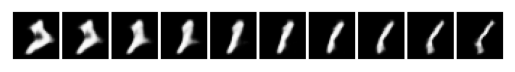

In [ ]:
latent_dim = 16  # Set the desired number of latent dimensions
num_steps = 10  # Set the number of interpolation steps

interpolate_samples(model, latent_dim, num_steps)


Short utility function that I search for a lot:

In [ ]:
model.load_state_dict(torch.load('vae_weights.pth'))

<All keys matched successfully>